<a href="https://colab.research.google.com/github/brendatransito/Tumor-Image-Classification/blob/main/04_ResNet50_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Rentrenamiento de ResNet-50**

In [ ]:
# Imports y configuración

import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms, models

import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')


sys.path.append("/content/drive/MyDrive/Proyecto_PTI")

from prepare_dataset import load_clean_split_kaggle, BrainTumorDataset
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

BASE_DIR = "/kaggle/input/brain-tumor-mri-dataset"

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Carpeta donde se guardarán los modelos con ruido
MODEL_DIR = "/content/drive/MyDrive/Proyecto_PTI"
os.makedirs(MODEL_DIR, exist_ok=True)
print("Los modelos se guardarán en:", MODEL_DIR)


Mounted at /content/drive
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Usando device: cuda
Los modelos se guardarán en: /content/drive/MyDrive/Proyecto_PTI


In [ ]:

# Cargar split limpio (Train/Val/Test)

# Esta función debe regresar:
# (X_train, y_train), (X_val, y_val), (X_test, y_test), y classes
(X_train, y_train), (X_val, y_val), (X_test, y_test), classes = load_clean_split_kaggle(BASE_DIR)

print("Clases:", classes)

# Mapeo clase -> índice (consistente con prepare_dataloaders_kaggle)
class_to_idx = {cls: i for i, cls in enumerate(classes)}
print("class_to_idx:", class_to_idx)


Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009

Clases: ['glioma', 'meningioma', 'notumor', 'pituitary']
class_to_idx: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# ======================================
# 3. Funciones de entrenamiento / evaluación
# ======================================
def train_one_epoch(model, loader, optimizer, criterion):
    """
    Entrena un epoch completo.
    Devuelve: pérdida promedio y accuracy sobre el conjunto de entrenamiento.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def eval_one_epoch(model, loader, criterion):
    """
    Evalúa el modelo en val/test.
    Devuelve: pérdida promedio y accuracy.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [ ]:
# Módulos de ruido gaussiano

class AddGaussianNoise(nn.Module):
    """
    Ruido gaussiano con std fijo. Útil para test loaders.
    """
    def __init__(self, mean=0.0, std=0.05):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        # tensor se asume en [0,1] antes de normalizar
        noise = torch.randn_like(tensor) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"


class RandomGaussianNoiseRange(nn.Module):
    """
    Aplica ruido gaussiano con probabilidad p.
    La desviación estándar se toma aleatoria en [std_min, std_max].
    Útil para entrenamiento, para que cada batch tenga std distinta.
    """
    def __init__(self, p=0.7, std_min=0.0, std_max=0.07):
        super().__init__()
        self.p = p
        self.std_min = std_min
        self.std_max = std_max

    def forward(self, tensor):
        if torch.rand(1).item() < self.p:
            std = torch.empty(1).uniform_(self.std_min, self.std_max).item()
            noise = torch.randn_like(tensor) * std
            return tensor + noise
        return tensor

    def __repr__(self):
        return (f"{self.__class__.__name__}(p={self.p}, "
                f"std_min={self.std_min}, std_max={self.std_max})")


In [ ]:
# Transforms
# (a) Transform estándar para val/test (sin ruido ni augment extra)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# (b) Train CON data augmentation + ruido aleatorio
train_transform_noisy_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    RandomGaussianNoiseRange(p=0.7, std_min=0.0, std_max=0.07),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# (c) Train SOLO con ruido (sin rotaciones, flips, etc.)
train_transform_noisy_only = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    RandomGaussianNoiseRange(p=0.7, std_min=0.0, std_max=0.07),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [ ]:
#  Datasets y Dataloaders


# --- Con augment + ruido ---
train_set_noise_aug = BrainTumorDataset(
    X_train, y_train,
    transform=train_transform_noisy_aug,
    class_to_idx=class_to_idx
)

# --- Con ruido pero SIN augment ---
train_set_noise_noaug = BrainTumorDataset(
    X_train, y_train,
    transform=train_transform_noisy_only,
    class_to_idx=class_to_idx
)

# Val y test limpios (sin ruido)
val_set = BrainTumorDataset(
    X_val, y_val,
    transform=val_test_transform,
    class_to_idx=class_to_idx
)

test_set_clean = BrainTumorDataset(
    X_test, y_test,
    transform=val_test_transform,
    class_to_idx=class_to_idx
)

# DataLoaders
batch_size = 32

train_loader_noise_aug = DataLoader(
    train_set_noise_aug, batch_size=batch_size,
    shuffle=True, num_workers=2
)

train_loader_noise_noaug = DataLoader(
    train_set_noise_noaug, batch_size=batch_size,
    shuffle=True, num_workers=2
)

val_loader = DataLoader(
    val_set, batch_size=batch_size,
    shuffle=False, num_workers=2
)

test_loader_clean = DataLoader(
    test_set_clean, batch_size=batch_size,
    shuffle=False, num_workers=2
)

print("Tamaño train (aug+ruido):", len(train_set_noise_aug))
print("Tamaño train (ruido sin aug):", len(train_set_noise_noaug))
print("Tamaño val:", len(val_set))
print("Tamaño test:", len(test_set_clean))


Tamaño train (aug+ruido): 4708
Tamaño train (ruido sin aug): 4708
Tamaño val: 1009
Tamaño test: 1009


In [ ]:
# Función para crear ResNet-50

def create_resnet50_model(num_classes):
    """
    Crea una ResNet-50 preentrenada en ImageNet,
    reemplazando la última capa totalmente conectada.
    """
    model = models.resnet50(weights="IMAGENET1K_V2")
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, num_classes)
    )
    return model.to(device)


In [ ]:
# Entrenamiento: ResNet-50 con augment + ruido

EPOCHS = 10  # ajusta si quieres más

model_noise_aug = create_resnet50_model(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_noise_aug.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

history_noise_aug = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}
best_val_loss_aug = float("inf")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model_noise_aug, train_loader_noise_aug, optimizer, criterion
    )
    val_loss, val_acc = eval_one_epoch(
        model_noise_aug, val_loader, criterion
    )

    history_noise_aug["train_loss"].append(train_loss)
    history_noise_aug["val_loss"].append(val_loss)
    history_noise_aug["train_acc"].append(train_acc)
    history_noise_aug["val_acc"].append(val_acc)

    scheduler.step(val_loss)

    print(f"\n[ResNet50 - Aug+Ruido] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Guardar mejor modelo según pérdida de validación
    if val_loss < best_val_loss_aug:
        best_val_loss_aug = val_loss
        best_path = os.path.join(MODEL_DIR, "resnet50_noise_aug_best.pth")
        torch.save(model_noise_aug.state_dict(), best_path)
        print(f"  ✔ Mejor modelo (aug+ruido) guardado en: {best_path}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]



[ResNet50 - Aug+Ruido] Epoch 1/10
  Train Loss: 0.5918 | Train Acc: 0.7870
  Val   Loss: 0.2435 | Val   Acc: 0.9098
  ✔ Mejor modelo (aug+ruido) guardado en: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_aug_best.pth

[ResNet50 - Aug+Ruido] Epoch 2/10
  Train Loss: 0.2126 | Train Acc: 0.9259
  Val   Loss: 0.1211 | Val   Acc: 0.9594
  ✔ Mejor modelo (aug+ruido) guardado en: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_aug_best.pth

[ResNet50 - Aug+Ruido] Epoch 3/10
  Train Loss: 0.1463 | Train Acc: 0.9526
  Val   Loss: 0.0913 | Val   Acc: 0.9693
  ✔ Mejor modelo (aug+ruido) guardado en: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_aug_best.pth

[ResNet50 - Aug+Ruido] Epoch 4/10
  Train Loss: 0.1062 | Train Acc: 0.9662
  Val   Loss: 0.0839 | Val   Acc: 0.9673
  ✔ Mejor modelo (aug+ruido) guardado en: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_aug_best.pth

[ResNet50 - Aug+Ruido] Epoch 5/10
  Train Loss: 0.0792 | Train Acc: 0.9771
  Val   Loss: 0.0641 | Val   Acc

In [ ]:
# Entrenamiento: ResNet-50 con ruido SIN augment

model_noise_noaug = create_resnet50_model(len(classes))
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.AdamW(model_noise_noaug.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2, mode='min', factor=0.1, patience=3
)

history_noise_noaug = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}
best_val_loss_noaug = float("inf")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model_noise_noaug, train_loader_noise_noaug, optimizer2, criterion2
    )
    val_loss, val_acc = eval_one_epoch(
        model_noise_noaug, val_loader, criterion2
    )

    history_noise_noaug["train_loss"].append(train_loss)
    history_noise_noaug["val_loss"].append(val_loss)
    history_noise_noaug["train_acc"].append(train_acc)
    history_noise_noaug["val_acc"].append(val_acc)

    scheduler2.step(val_loss)

    print(f"\n[ResNet50 - Ruido sin Aug] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss_noaug:
        best_val_loss_noaug = val_loss
        best_path = os.path.join(MODEL_DIR, "resnet50_noise_noaug_best.pth")
        torch.save(model_noise_noaug.state_dict(), best_path)
        print(f"  ✔ Mejor modelo (ruido sin aug) guardado en: {best_path}")



[ResNet50 - Ruido sin Aug] Epoch 1/10
  Train Loss: 0.5226 | Train Acc: 0.8163
  Val   Loss: 0.1178 | Val   Acc: 0.9564
  ✔ Mejor modelo (ruido sin aug) guardado en: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_noaug_best.pth

[ResNet50 - Ruido sin Aug] Epoch 2/10
  Train Loss: 0.1363 | Train Acc: 0.9509
  Val   Loss: 0.0592 | Val   Acc: 0.9841
  ✔ Mejor modelo (ruido sin aug) guardado en: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_noaug_best.pth

[ResNet50 - Ruido sin Aug] Epoch 3/10
  Train Loss: 0.0707 | Train Acc: 0.9768
  Val   Loss: 0.0665 | Val   Acc: 0.9752

[ResNet50 - Ruido sin Aug] Epoch 4/10
  Train Loss: 0.0471 | Train Acc: 0.9826
  Val   Loss: 0.0332 | Val   Acc: 0.9871
  ✔ Mejor modelo (ruido sin aug) guardado en: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_noaug_best.pth

[ResNet50 - Ruido sin Aug] Epoch 5/10
  Train Loss: 0.0438 | Train Acc: 0.9868
  Val   Loss: 0.0355 | Val   Acc: 0.9871

[ResNet50 - Ruido sin Aug] Epoch 6/10
  Train Loss: 0.0213

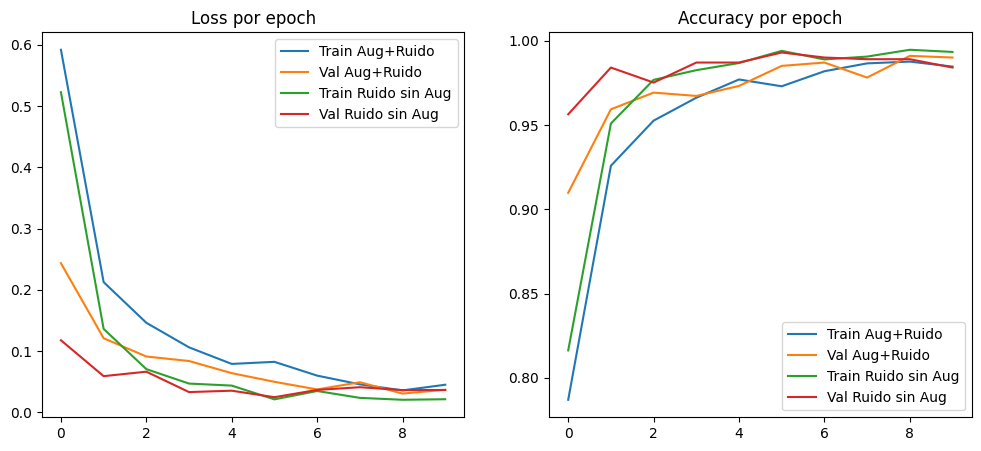

In [ ]:
# Gráficas de entrenamiento

plt.figure(figsize=(12,5))

# --- Pérdida ---
plt.subplot(1,2,1)
plt.plot(history_noise_aug["train_loss"], label="Train Aug+Ruido")
plt.plot(history_noise_aug["val_loss"],   label="Val Aug+Ruido")
plt.plot(history_noise_noaug["train_loss"], label="Train Ruido sin Aug")
plt.plot(history_noise_noaug["val_loss"],   label="Val Ruido sin Aug")
plt.title("Loss por epoch")
plt.legend()

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(history_noise_aug["train_acc"], label="Train Aug+Ruido")
plt.plot(history_noise_aug["val_acc"],   label="Val Aug+Ruido")
plt.plot(history_noise_noaug["train_acc"], label="Train Ruido sin Aug")
plt.plot(history_noise_noaug["val_acc"],   label="Val Ruido sin Aug")
plt.title("Accuracy por epoch")
plt.legend()

plt.show()


In [ ]:
def get_all_preds(model, loader, device):
    """
    Recorre todo el loader y regresa:
    - y_true: etiquetas verdaderas (numpy array)
    - y_pred: etiquetas predichas (numpy array)
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    return y_true, y_pred


In [ ]:
# ResNet-50 entrenada con Aug + ruido

y_true_aug, y_pred_aug = get_all_preds(model_noise_aug, test_loader_clean, device)

print("===============================================")
print(" ResNet-50 ENTRENADA CON Augment + Ruido ")
print(" (evaluada en TEST limpio, sin ruido) ")
print("===============================================")

print(classification_report(
    y_true_aug,
    y_pred_aug,
    target_names=classes,
    digits=4
))

cm_aug = confusion_matrix(y_true_aug, y_pred_aug)
print("Matriz de confusión (Aug+Ruido):")
print(cm_aug)


 ResNet-50 ENTRENADA CON Augment + Ruido 
 (evaluada en TEST limpio, sin ruido) 
              precision    recall  f1-score   support

      glioma     0.9958    0.9835    0.9896       243
  meningioma     0.9877    0.9797    0.9837       246
     notumor     0.9811    1.0000    0.9904       259
   pituitary     1.0000    1.0000    1.0000       261

    accuracy                         0.9911      1009
   macro avg     0.9911    0.9908    0.9909      1009
weighted avg     0.9911    0.9911    0.9911      1009

Matriz de confusión (Aug+Ruido):
[[239   3   1   0]
 [  1 241   4   0]
 [  0   0 259   0]
 [  0   0   0 261]]


In [ ]:
# ResNet-50 entrenada SIN Aug (solo ruido)

y_true_noaug, y_pred_noaug = get_all_preds(model_noise_noaug, test_loader_clean, device)

print("\n===============================================")
print(" ResNet-50 ENTRENADA SIN Augment (solo ruido) ")
print(" (evaluada en TEST limpio, sin ruido) ")
print("===============================================")

print(classification_report(
    y_true_noaug,
    y_pred_noaug,
    target_names=classes,
    digits=4
))

cm_noaug = confusion_matrix(y_true_noaug, y_pred_noaug)
print("Matriz de confusión (sin Aug, solo ruido):")
print(cm_noaug)



 ResNet-50 ENTRENADA SIN Augment (solo ruido) 
 (evaluada en TEST limpio, sin ruido) 
              precision    recall  f1-score   support

      glioma     0.9634    0.9753    0.9693       243
  meningioma     0.9957    0.9472    0.9708       246
     notumor     0.9961    0.9923    0.9942       259
   pituitary     0.9631    1.0000    0.9812       261

    accuracy                         0.9792      1009
   macro avg     0.9796    0.9787    0.9789      1009
weighted avg     0.9796    0.9792    0.9791      1009

Matriz de confusión (sin Aug, solo ruido):
[[237   1   0   5]
 [  9 233   1   3]
 [  0   0 257   2]
 [  0   0   0 261]]


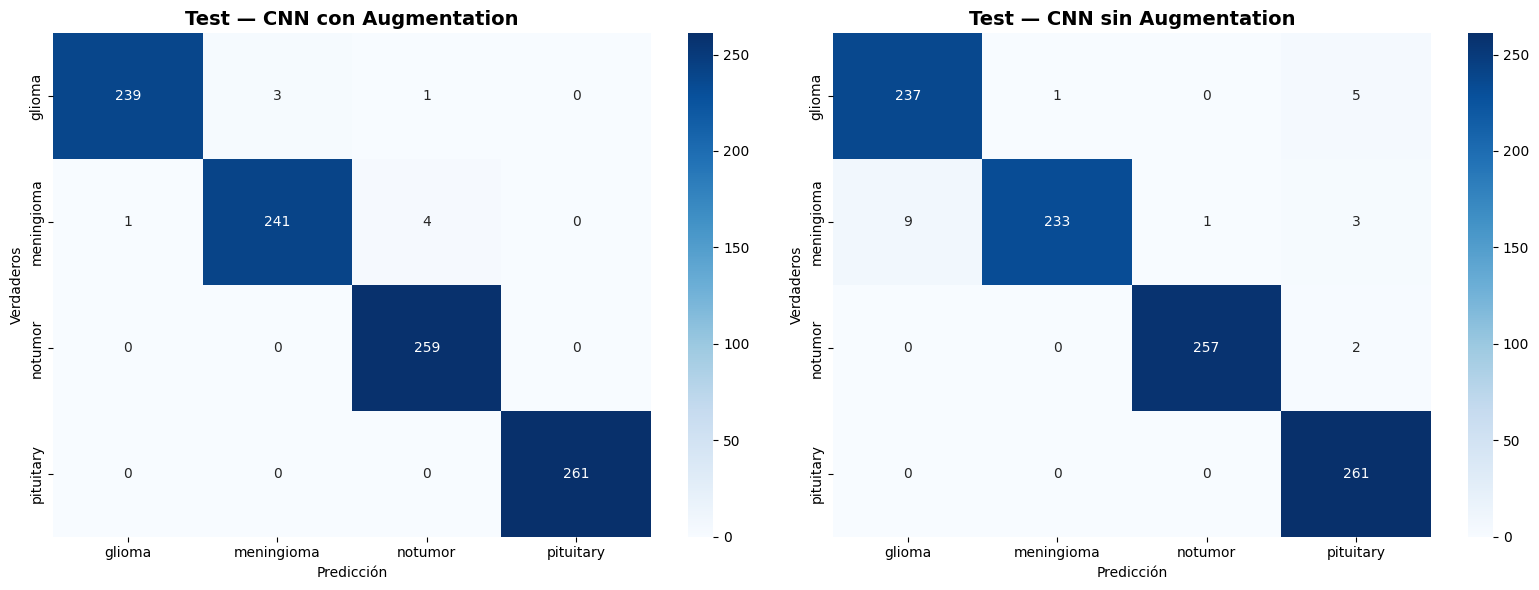

In [ ]:
#  Matrices de confusión


cm_aug = confusion_matrix(y_true_aug, y_pred_aug)
cm_noaug = confusion_matrix(y_true_noaug, y_pred_noaug)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#  MODELO CON AUGMENT

sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            ax=axes[0])

axes[0].set_title("Test — CNN con Augmentation", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Verdaderos")


# MODELO SIN AUGMENT
sns.heatmap(cm_noaug, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            ax=axes[1])

axes[1].set_title("Test — CNN sin Augmentation", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Verdaderos")

plt.tight_layout()
plt.show()
